# Forces in the simulation

The simulation part of 'icenumerics' is done through the 'magcolloids' package, which works as a wrapper of the molecular dynamics program [LAMMPS](https://lammps.sandia.gov/doc/Manual.html). In molecular dynamics, the equations of motion of all particles are solved by discretizing them, and applying a velocity verlet algorithm. The equations of motion are given by Newton's equation: 
$$m_i\ddot{\vec{x_i}} = \vec{F_i}$$

## Brownian Dynamics
The 'icenumerics' and 'magcolloids' packages use a modified version of LAMMPS, to instead run Brownian dynamics. In Brownian dynamics, particles are assumed to be immersed in a high Reynolds number fluid, so that:
* A viscous drag force is included in the force balance, which is proportional to the velocity $F_{i,drag} = -\gamma\dot{\vec{x_i}}$. 
* This viscous force is assumed to be much larger than the inertial term $m_i\vec{\ddot{x_i}}$, so the later can be neglected.
* Particles are subjected to random kicks from the fluid. These are given by a Langevin thermostat which is a random variable $\eta$ such that $\left<\eta\right> = 0$ and $\left<\eta_i(t+\Delta t)\eta_j(t)\right> = 2k_BT\gamma\delta({i-j})\delta({\Delta t})$, where $\delta$ is the Dirac delta function.

The result from these assumptions is that the force balance can be written:
$$\gamma\dot{\vec{x_i}} = \vec{F_i} + \eta$$
which can be discretized as:
$$\Delta{\vec{x_i}} = \frac{\Delta t}{\gamma}\vec{F_i} + \sqrt{\Delta t 2k_BT\gamma}N[0,1]$$ 
where $N[0,1]$ is a Gaussian distributed random variable with zero mean and unitary variance. 
This is the equation that is used to solve the trajectories of particles.

## Available Forces 

In [1]:
# This only adds the package to the path.
import os
import sys 
sys.path.insert(0, '../../')

import magcolloids as mgc
import numpy as np

import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

There are two components that are fundamental to Colloidal Ice: the trapping force and the interaction force. 

### Trapping Force

Colloidal Ice consists of colloidal particles confined to a bistable potential, so that particles can jump from one stability position to another in a way that minimizes the energy of the system. The potential used by the 'icenumerics' package is a bi-harmonic potential, defined by:

$$
F = -k r_{\perp} \hat{e}_{\perp} + \hat{e}_{||}
\begin{cases}
k \left(|r_{||}|-d/2\right) \mathrm{sign}\left(r_{||}\right) & r_{||}<d/2 \\
h\left(1-\frac{8r_{||}^2}{d^2}\right) & r_{||}>d/2
\end{cases}
$$

where $r_{||}$ is the component parallel to the direction of the trap, and $r_{\perp}$ is the perpendicular component, $\hat{e}_{||}$ is the unit vector in the direction of the trap, $\hat{e}_{||}$ a vector pointing away from the line that joins both stable points, $k$ is the trap stiffness, $d$ is the distance between centers, and $h$ is the height of the central hill.  

This expression can be checked by allowing a particle to diffuse thermally through a trap, and observing its probability distribution. To do this, we run a single particle on a single trap. 

In [2]:
ureg = mgc.ureg

In [3]:
region = np.array([20,20,4.1])

particles = mgc.particles(
    np.array([[-1.5,0,0]])*ureg.um,
    radius = 2*ureg.um,
    susceptibility = 1,
    diffusion=0.07*ureg.um**2/ureg.s,
    density = 0*ureg.kg/ureg.m**3,
    temperature=300*ureg.K)

traps = mgc.bistable_trap(
                np.array([[0,0,0]])*ureg.um,
                np.array([[1,0,0]]),
                particles,
                distance = 1.5*ureg.um,
                height = 8 * ureg.pN*ureg.nm,
                stiffness = 3e-4 * ureg.pN/ureg.nm)

In [4]:
field = mgc.field(magnitude = 0*ureg.mT, frequency = 100*ureg.Hz, angle = 90*ureg.degrees)

world = mgc.world(particles, traps, temperature = 300*ureg.K,
                  region=region*ureg.um, boundaries = ['p','p','f'], walls = [False,False,True],
                  dipole_cutoff = 20*ureg.um)

sim = mgc.sim(dir_name = "forces/", file_name = "test_traps",
       timestep = 1e-3*ureg.s, framerate = 30*ureg.Hz, total_time = 3000*ureg.s,
       particles = particles, traps = traps, world = world, field = field, 
       output = ["x","y","z","mux","muy","muz","fx","fy","fz"])

In [5]:
%%time 

sim.generate_scripts()
sim.run()
sim.load()

scanning file


  0%|          | 0/36099673 [00:00<?, ?it/s]

CPU times: user 3.8 s, sys: 270 ms, total: 4.07 s
Wall time: 49 s


In [6]:
%%time 
trj = sim.lazy_read[:]

[autoreload of magcolloids.parameters failed: Traceback (most recent call last):
  File "/Users/aortiza/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 273, in check
    superreload(m, reload, self.old_objects)
  File "/Users/aortiza/opt/anaconda3/lib/python3.9/site-packages/IPython/extensions/autoreload.py", line 471, in superreload
    module = reload(module)
  File "/Users/aortiza/opt/anaconda3/lib/python3.9/importlib/__init__.py", line 169, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 613, in _exec
  File "<frozen importlib._bootstrap_external>", line 846, in exec_module
  File "<frozen importlib._bootstrap_external>", line 983, in get_code
  File "<frozen importlib._bootstrap_external>", line 913, in source_to_code
  File "<frozen importlib._bootstrap>", line 228, in _call_with_frames_removed
  File "/Users/aortiza/Desktop/icenumerics/icenumerics/magcolloids/docs/source/../../magcolloids/parameters.py",

CPU times: user 1min 4s, sys: 4.52 s, total: 1min 9s
Wall time: 1min 14s


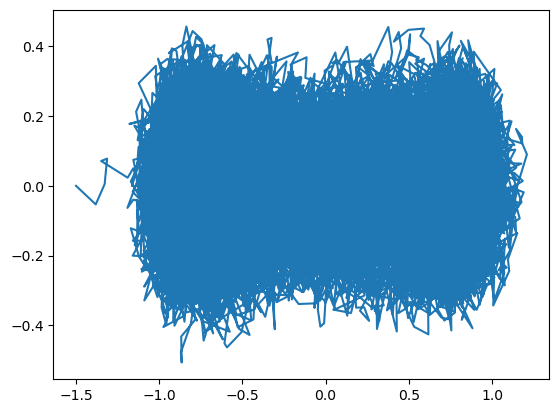

In [7]:
plt.plot(trj[trj.type==1].x, trj[trj.type==1].y)

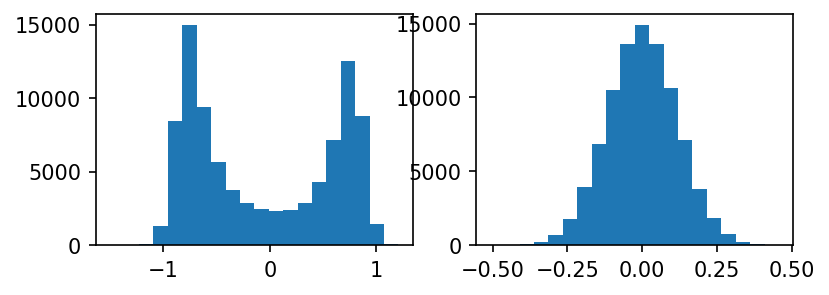

In [8]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)
ax[0].hist(trj[trj.type==1].x, bins=20);
ax[1].hist(trj[trj.type==1].y, bins=20);

In [9]:
kB = 1.38064852e-23*ureg.J/ureg.K

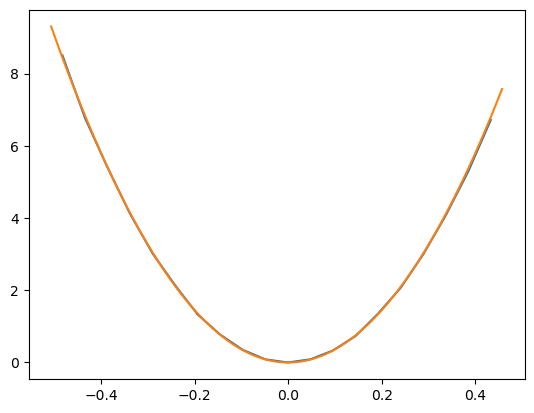

In [10]:
[p, x] = np.histogram(trj[trj.type==1].y, bins = 20, density=True)

plt.plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p))

k = traps.stiffness
x = np.linspace(min(x),max(x),1000) * ureg.um
T = sim.world.temperature

plt.plot(x.magnitude, (k*x**2/2/(kB*T)).to("").magnitude)

/var/folders/ff/fjvdcsjj6fvgz3jk_zhhy_dw0000gn/T/ipykernel_28932/3712050443.py:3: RuntimeWarning: divide by zero encountered in log
  plt.plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p))


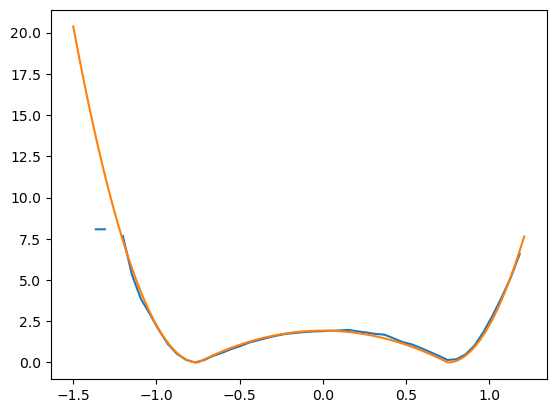

In [12]:
[p, x] = np.histogram(trj[trj.type==1].x, bins = 50, density=True)

plt.plot(x[1:]-np.diff(x)/2, max(np.log(p))-np.log(p))

x = np.linspace(min(x),max(x),1000) * ureg.um

k = traps.stiffness
d = traps.distance
h = traps.height
T = sim.world.temperature

U1 = (k * (abs(x)-d/2)**2 / 2).to(ureg.pN * ureg.nm)

U2 = (h*(1-4 * (x)**2/d**2)).to(ureg.pN * ureg.nm)
U = U2
U[abs(x)>(d/2)] = U1[abs(x)>(d/2)]

plt.plot(x.magnitude,(U/(kB*T)).to("").magnitude)

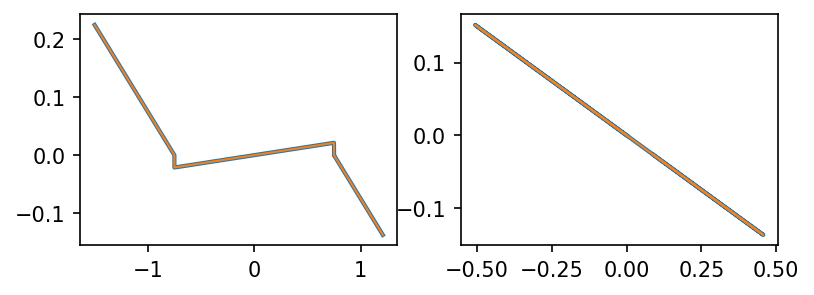

In [13]:
fig, ax = plt.subplots(1,2,figsize=(6,2),dpi=150)
forces = trj[trj.type==1]
forces = forces.sort_values(by="x")

x = forces.x
y = forces.y

fx = forces.fx * (1*ureg.pg*ureg.um/ureg.us**2).to(ureg.pN).magnitude
fy = forces.fy * (1*ureg.pg*ureg.um/ureg.us**2).to(ureg.pN).magnitude

F1 = -np.sign(x)*(abs(x)-d.magnitude/2)*(k.to(ureg.pN/ureg.um).magnitude)
F2 = x*(8*h/d**2).to(ureg.pN/ureg.um).magnitude
Fx = F2
Fx[abs(x)>(d.magnitude/2)] = F1[abs(x)>(d.magnitude/2)]

ax[0].plot(x,fx,linewidth = 2)
ax[0].plot(x, Fx,linewidth = 1)

Fy = -y*(k.to(ureg.pN/ureg.um).magnitude)

ax[1].plot(y,fy,linewidth = 2)
ax[1].plot(y,Fy,linewidth = 1)